In [19]:
import findspark
findspark.init()

from pyspark import  SparkContext
from pyspark.sql import SparkSession
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Building the SparkSession. Our workers has 2 cores each, and the total number of cores to be used are configured
#with the spark.cores.max parameter
def build_session(cores: int):
    spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.243:7077") \
        .appName("scalability test")\
        .config("spark.executor.cores", 2)\
        .config("spark.cores.max", cores)\
        .getOrCreate()
    return spark_session

In [15]:
#Scalability analysis (Strong Scaling)

number_of_cores = [2, 4, 6, 8]
results_strong = []

#This loop takes the number of cores declared in number_of_cores and starts a SparkSession with the specified
#number of cores
for cores in number_of_cores:
    #Building session and SparkContext
    spark_session = build_session(cores)
    spark_context = spark_session.sparkContext
    
    #Starting timer for reading the files
    start_time = time.time()
    #Reading the file that is stored in HDFS
    df1 = spark_session.read\
    .option("header","true")\
    .option("delimiter", "\t")\
    .csv("hdfs://team-4-master:9000/1000genomes/All.chr22.E1129_UNION_GL.20110521.snp.exome.genotypes_processed.vcf")
    read_time = time.time() - start_time
    
    #Starting the timer for executing the analysis
    start_time_execution = time.time()
    
    #Filter out others and only keep the SNP alleles data
    df2 = df1.select("REF","ALT")
    
    #Combine the two column so that now we have a column showing the mutation of the SNP e.g. mutated from a G to an A
    df2.createOrReplaceTempView("df2")
    df3 = spark_session.sql("SELECT CONCAT(REF, 'to',  ALT) as Mutation FROM df2")
    
    #We now can know which mutation is the most common one in this chromosome.
    df4 = df3.select("Mutation").groupBy("Mutation").count().sort("count", ascending=False).show()
    
    #Calculating the time for executing the analysis and store the result
    execution_time = time.time() - start_time_execution
    total_time = time.time() - start_time
    results_strong.append((cores, total_time, read_time, execution_time))
    
    #Stopping the spark context
    spark_context.stop()

#Store the result as a Pandas DataFrame
df_results_strong = pd.DataFrame(data=results_strong, columns=["Cores", "Total time", "Read time", "Execution time"])
df_results_strong

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|114818|
|    CtoT|113628|
|    TtoC| 55770|
|    AtoG| 55603|
|    CtoG| 21970|
|    GtoC| 21568|
|    GtoT| 20552|
|    CtoA| 20481|
|    AtoC| 13759|
|    TtoG| 13514|
|    AtoT| 11997|
|    TtoA| 11711|
+--------+------+

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|114818|
|    CtoT|113628|
|    TtoC| 55770|
|    AtoG| 55603|
|    CtoG| 21970|
|    GtoC| 21568|
|    GtoT| 20552|
|    CtoA| 20481|
|    AtoC| 13759|
|    TtoG| 13514|
|    AtoT| 11997|
|    TtoA| 11711|
+--------+------+

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|114818|
|    CtoT|113628|
|    TtoC| 55770|
|    AtoG| 55603|
|    CtoG| 21970|
|    GtoC| 21568|
|    GtoT| 20552|
|    CtoA| 20481|
|    AtoC| 13759|
|    TtoG| 13514|
|    AtoT| 11997|
|    TtoA| 11711|
+--------+------+

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|114818|
|    CtoT|113628|
|    TtoC| 55770|
|    AtoG| 55603|
|    Ct

,Cores,Total time,Read time,Execution time
0,2,123.585374,7.487733,116.097636
1,4,88.166967,7.262195,80.904767
2,6,77.764634,6.413300,71.351308
3,8,71.234103,6.333769,64.900329


In [20]:
#Visualizing the DataFrame in bigger size
df_results_strong.style.set_table_attributes('style="font-size: 18px"')

,Cores,Total time,Read time,Execution time
0,2,123.585374,7.487733,116.097636
1,4,88.166967,7.262195,80.904767
2,6,77.764634,6.413300,71.351308
3,8,71.234103,6.333769,64.900329


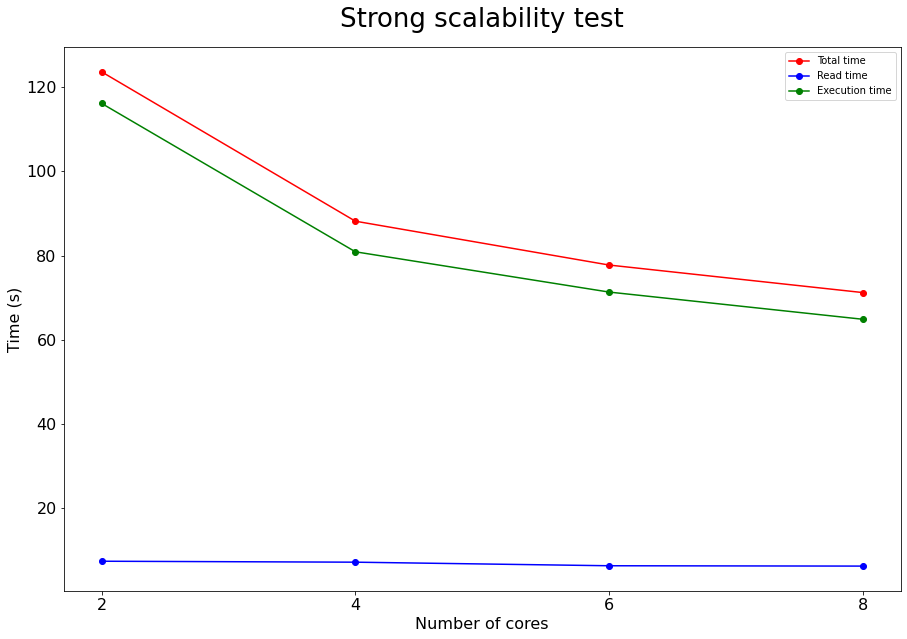

In [21]:
#Plot the results for the strong scalability test

fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.gca()

df_results_strong.plot(kind='line',x='Cores',y='Total time', color='red', ax=ax, marker="o")
df_results_strong.plot(kind='line',x='Cores',y='Read time', color='blue', ax=ax, marker="o")
df_results_strong.plot(kind='line',x='Cores',y='Execution time', color='green', ax=ax, marker="o")

plt.rc('axes', labelsize=16, titlesize=26, titlepad=20)
plt.xticks(np.arange(2, 9, step=2))
plt.title('Strong scalability test')
plt.ylabel('Time (s)')
plt.xlabel('Number of cores')
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.savefig('plot_strong.png')
plt.show()

In [26]:
#Scalability analysis (Weak Scaling)

number_of_cores = [2, 4, 6, 8]
files= ["hdfs://team-4-master:9000/1000genomes/All.chr22.E1129_UNION_GL.20110521.snp.exome.genotypes_processed.vcf",
        "hdfs://team-4-master:9000/1000genomes/All.chr22.E1129_UNION_GL.20110521.snp.exome.genotypes_processed.vcf",
        "hdfs://team-4-master:9000/1000genomes/All.chr22.E1129_UNION_GL.20110521.snp.exome.genotypes_processed.vcf",
        "hdfs://team-4-master:9000/1000genomes/All.chr22.E1129_UNION_GL.20110521.snp.exome.genotypes_processed.vcf"]
#We loop over the same file, an easy way to make sure that the files that are added have the same size.
#This doesn't make sence in regard to the analysis, but to test scalability this is a reasonable solution.

results_weak = []
results_weak_detailed = []

#This function read the files according to the given number of files (based on the number of cores)
def read_files(spark_session, path):
    df1 = spark_session.read\
    .option("header","true")\
    .option("delimiter", "\t")\
    .csv(path)
    return df1

#This loop takes the number of cores declared in number_of_cores and starts a SparkSession with the specified
#number of cores
for index, cores in enumerate(number_of_cores):
    #Build Session
    spark_session = build_session(cores)
    spark_context = spark_session.sparkContext
    
    #Starting timer for reading the files
    w_start_time = time.time()
    number_of_files = index+1
    #Reading the file that is stored in HDFS
    df1 = read_files(spark_session, files[0 : number_of_files])
    w_read_time = time.time() - w_start_time
    
    #Starting the timer for executing the analysis
    w_start_time_execution = time.time()
    #Starting the timer for the filtering stage in the execution
    w_start_time_filter = time.time()
    #Filter out others and only keep the SNP alleles data
    df2 = df1.select("REF","ALT")
    w_filter_time = time.time() - w_start_time_filter
    
    #Starting the timer for the concatenate stage in the execution
    w_start_time_concat = time.time()
    #Combine the two column so that now we have a column showing the mutation of the SNP e.g. mutated from a G to an A
    df2.createOrReplaceTempView("df2")
    df3 = spark_session.sql("SELECT CONCAT(REF, 'to',  ALT) as Mutation FROM df2")
    w_concat_time = time.time() - w_start_time_concat
    
    #Starting the timer for the group by stage in the execution
    w_start_time_groupBy = time.time()
    #We now can know which mutation is the most common one in this chromosome.
    df4 = df3.select("Mutation").groupBy("Mutation").count().sort("count", ascending=False).show()
    w_groupBy_time = time.time() - w_start_time_groupBy
    
    #Calculating the time for executing the analysis and store the result
    w_execution_time = time.time() - w_start_time_execution
    w_total_time = time.time() - w_start_time
    results_weak.append((cores, number_of_files, w_total_time, w_read_time, w_execution_time))
    results_weak_detailed.append((cores, number_of_files, w_total_time, w_read_time, w_execution_time, w_filter_time, w_concat_time, w_groupBy_time,))
    
    #Stopping the spark context
    spark_context.stop()

# Store the result as a Pandas DataFrame
df_results_weak = pd.DataFrame(data=results_weak, columns=["Cores", "Number of files", "Total time", "Read time", "Execution time"])
df_results_weak_detailed = pd.DataFrame(data=results_weak_detailed, columns=["Cores", "Number of files", "Total time", "Read time", "Execution time", "Filter time", "ConCat time", "GroupBy time"])
df_results_weak
df_results_weak_detailed

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|114818|
|    CtoT|113628|
|    TtoC| 55770|
|    AtoG| 55603|
|    CtoG| 21970|
|    GtoC| 21568|
|    GtoT| 20552|
|    CtoA| 20481|
|    AtoC| 13759|
|    TtoG| 13514|
|    AtoT| 11997|
|    TtoA| 11711|
+--------+------+

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|229636|
|    CtoT|227256|
|    TtoC|111540|
|    AtoG|111206|
|    CtoG| 43940|
|    GtoC| 43136|
|    GtoT| 41104|
|    CtoA| 40962|
|    AtoC| 27518|
|    TtoG| 27028|
|    AtoT| 23994|
|    TtoA| 23422|
+--------+------+

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|344454|
|    CtoT|340884|
|    TtoC|167310|
|    AtoG|166809|
|    CtoG| 65910|
|    GtoC| 64704|
|    GtoT| 61656|
|    CtoA| 61443|
|    AtoC| 41277|
|    TtoG| 40542|
|    AtoT| 35991|
|    TtoA| 35133|
+--------+------+

+--------+------+
|Mutation| count|
+--------+------+
|    GtoA|459272|
|    CtoT|454512|
|    TtoC|223080|
|    AtoG|222412|
|    Ct

,Cores,Number of files,Total time,Read time,Execution time,Filter time,ConCat time,GroupBy time
0,2,1,211.568541,9.993632,201.574905,0.017542,0.022772,201.534582
1,4,2,210.780213,6.467796,204.312412,0.016462,0.020115,204.275829
2,6,3,257.514982,7.721275,249.793704,0.013559,0.020005,249.760133
3,8,4,283.155273,6.450804,276.704454,0.021965,0.022704,276.659776


In [30]:
#Visualizing the DataFrame in bigger size
df_results_weak.style.set_table_attributes('style="font-size: 16px"')

,Cores,Number of files,Total time,Read time,Execution time
0,2,1,211.568541,9.993632,201.574905
1,4,2,210.780213,6.467796,204.312412
2,6,3,257.514982,7.721275,249.793704
3,8,4,283.155273,6.450804,276.704454


In [29]:
#Visualizing the DataFrame in bigger size
df_results_weak_detailed.style.set_table_attributes('style="font-size: 16px"')

,Cores,Number of files,Total time,Read time,Execution time,Filter time,ConCat time,GroupBy time
0,2,1,211.568541,9.993632,201.574905,0.017542,0.022772,201.534582
1,4,2,210.780213,6.467796,204.312412,0.016462,0.020115,204.275829
2,6,3,257.514982,7.721275,249.793704,0.013559,0.020005,249.760133
3,8,4,283.155273,6.450804,276.704454,0.021965,0.022704,276.659776


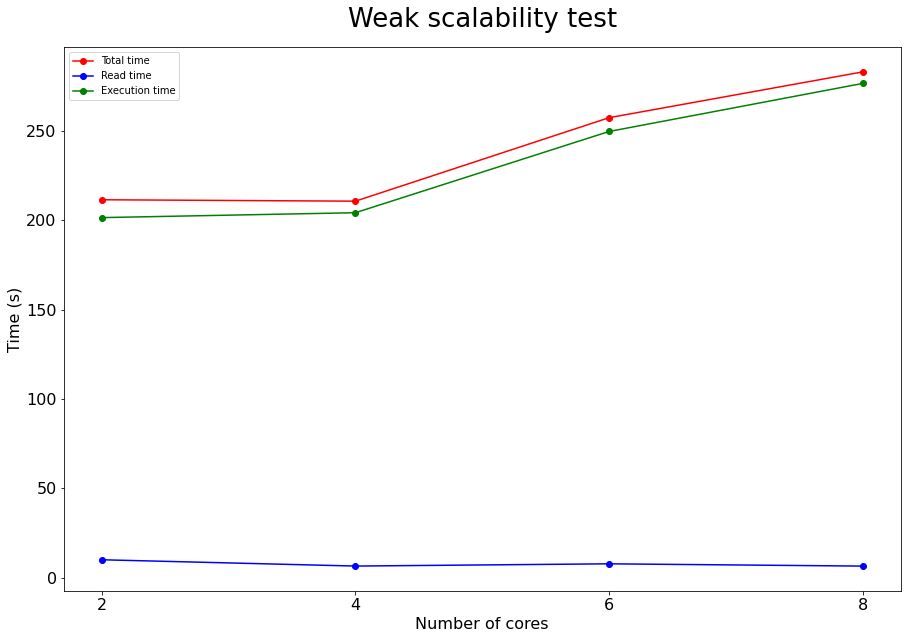

In [31]:
#Plot the result for the weak scalability test

fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.gca()

df_results_weak.plot(kind='line',x='Cores',y='Total time', color='red', ax=ax, marker="o")
df_results_weak.plot(kind='line',x='Cores',y='Read time', color='blue', ax=ax, marker="o")
df_results_weak.plot(kind='line',x='Cores',y='Execution time', color='green', ax=ax, marker="o")

plt.rc('axes', labelsize=16, titlesize=26, titlepad=20)
plt.xticks(np.arange(2, 9, step=2))
plt.title('Weak scalability test')
plt.ylabel('Time (s)')
plt.xlabel('Number of cores')
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.savefig('plot_weak.png')
plt.show()

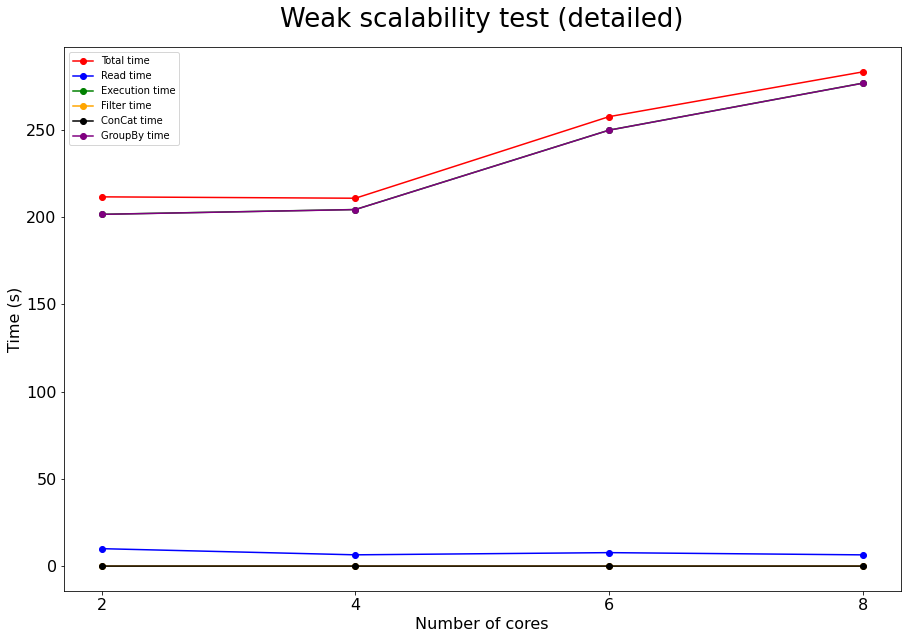

In [33]:
#Plot the second result for the detailed weak scalability test

fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.gca()

df_results_weak_detailed.plot(kind='line',x='Cores',y='Total time', color='red', ax=ax, marker="o")
df_results_weak_detailed.plot(kind='line',x='Cores',y='Read time', color='blue', ax=ax, marker="o")
df_results_weak_detailed.plot(kind='line',x='Cores',y='Execution time', color='green', ax=ax, marker="o")
df_results_weak_detailed.plot(kind='line',x='Cores',y='Filter time', color='orange', ax=ax, marker="o")
df_results_weak_detailed.plot(kind='line',x='Cores',y='ConCat time', color='black', ax=ax, marker="o")
df_results_weak_detailed.plot(kind='line',x='Cores',y='GroupBy time', color='purple', ax=ax, marker="o")

plt.rc('axes', labelsize=16, titlesize=26, titlepad=20)
plt.xticks(np.arange(2, 9, step=2))
plt.title('Weak scalability test (detailed)')
plt.ylabel('Time (s)')
plt.xlabel('Number of cores')
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.savefig('plot_weak_detalied.png')
plt.show()